# Problem Statement

Problem statement: To build a CNN based model which can accurately detect melanoma. Melanoma is a type of cancer that can be deadly if not detected early. It accounts for 75% of skin cancer deaths. 

# Solution 
A solution which can evaluate images and alert the dermatologists about the presence of melanoma has the potential to reduce a lot of manual effort needed in diagnosis.

# Importing libs

In [41]:
import pathlib
import tensorflow as tf
import matplotlib.pyplot as plt
import numpy as np
import pandas as pd
import os
import PIL
from tensorflow import keras
from tensorflow.keras import layers,models
from tensorflow.keras.models import Sequential
from keras.layers import Dense, Dropout, Flatten, Conv2D, MaxPool2D
from tensorflow.keras.optimizers import Adam 
import random
from glob import glob
import seaborn as sns
from tensorflow.keras.losses import SparseCategoricalCrossentropy
import matplotlib.pyplot as plt
import matplotlib.image as img
import warnings
warnings.filterwarnings('ignore')

In [42]:
gpus = tf.config.experimental.list_physical_devices('GPU')
print(gpus)
try:
    tf.config.experimental.set_memory_growth = True
except Exception as ex:
    print(e)

[PhysicalDevice(name='/physical_device:GPU:0', device_type='GPU')]


In [3]:
! rm -rf /kaggle/working/data/

# Reading input data 

In [4]:
data_dir_train = pathlib.Path("../input/skin-cancer9-classesisic/Skin cancer ISIC The International Skin Imaging Collaboration/Train/")
data_dir_test = pathlib.Path("../input/skin-cancer9-classesisic/Skin cancer ISIC The International Skin Imaging Collaboration/Test/")

In [5]:
image_count_train = len(list(data_dir_train.glob('*/*.jpg')))
print(image_count_train)
image_count_test = len(list(data_dir_test.glob('*/*.jpg')))
print(image_count_test)

2239
118


# Prepare the dataset

In [13]:
batch_size = 32
img_height = 180
img_width = 180
rnd_seed = 123
random.seed(rnd_seed)

In [14]:
train_ds = tf.keras.preprocessing.image_dataset_from_directory(
  data_dir_train,
  validation_split=0.2,
  subset="training",
  seed=123,
  image_size=(img_height, img_width),
  batch_size=batch_size)

Found 2239 files belonging to 9 classes.
Using 1792 files for training.


In [15]:
val_ds = tf.keras.preprocessing.image_dataset_from_directory(
  data_dir_train,
  validation_split=0.2,
  subset="validation",
  seed=123,
  image_size=(img_height, img_width),
  batch_size=batch_size)


Found 2239 files belonging to 9 classes.
Using 447 files for validation.


In [16]:
test_ds = tf.keras.preprocessing.image_dataset_from_directory(
  data_dir_test,
  validation_split=0.9,
  subset="validation",
  seed=123,
  image_size=(img_height, img_width),
  batch_size=batch_size)

Found 118 files belonging to 9 classes.
Using 106 files for validation.


In [17]:
class_names = train_ds.class_names
print(class_names)

['actinic keratosis', 'basal cell carcinoma', 'dermatofibroma', 'melanoma', 'nevus', 'pigmented benign keratosis', 'seborrheic keratosis', 'squamous cell carcinoma', 'vascular lesion']


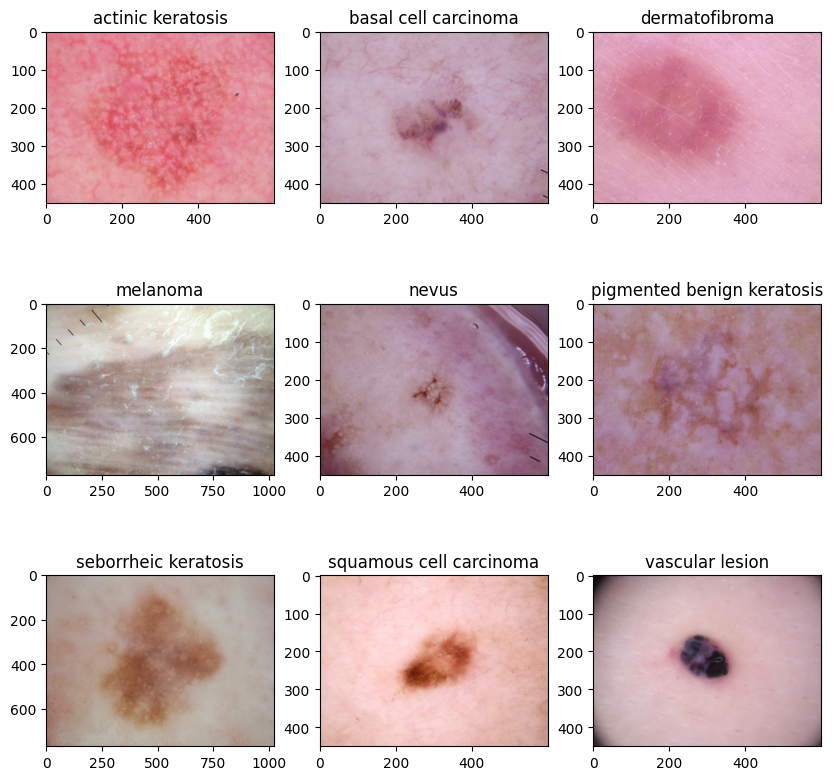

In [18]:
num_classes = len(class_names)
plt.figure(figsize=(10,10))
for i in range(num_classes):
  plt.subplot(3,3,i+1)
  image = img.imread(str(list(data_dir_train.glob(class_names[i]+'/*.jpg'))[1]))
  plt.title(class_names[i])
  plt.imshow(image)


In [19]:
for image_batch, labels_batch in train_ds.take(1):
    print(image_batch.shape)
    print(labels_batch.shape)

(32, 180, 180, 3)
(32,)


In [20]:
AUTOTUNE = tf.data.experimental.AUTOTUNE
train_ds = train_ds.cache().shuffle(1000).prefetch(buffer_size=AUTOTUNE)
val_ds = val_ds.cache().prefetch(buffer_size=AUTOTUNE)

# Model 1 : standard Model


In [23]:
num_classes = 9
model = Sequential([layers.Rescaling \
                    (1.0/255,input_shape=(img_height,img_width,3))])

model.add(Conv2D(32, 3,padding="same",activation='relu'))
model.add(MaxPool2D())

model.add(Conv2D(64, 3,padding="same",activation='relu'))
model.add(MaxPool2D())

model.add(Conv2D(128, 3,padding="same",activation='relu'))
model.add(MaxPool2D())

model.add(Conv2D(256, 3,padding="same",activation='relu'))
model.add(MaxPool2D())

model.add(Conv2D(512, 3,padding="same",activation='relu'))
model.add(MaxPool2D())

model.add(Flatten())
model.add(Dense(1024,activation="relu"))
model.add(Dense(units=num_classes, activation= 'softmax'))


In [25]:
opt = Adam(learning_rate=0.001)

# Compile the model
model.compile(optimizer=opt,
              loss=SparseCategoricalCrossentropy(from_logits=True),
              metrics=['accuracy'])

In [26]:
model.summary()

Model: "sequential"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ rescaling (Rescaling)           │ (None, 180, 180, 3)    │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv2d (Conv2D)                 │ (None, 180, 180, 32)   │           896 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ max_pooling2d (MaxPooling2D)    │ (None, 90, 90, 32)     │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv2d_1 (Conv2D)               │ (None, 90, 90, 64)     │        18,496 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ max_pooling2d_1 (MaxPooling2D)  │ (None, 45, 45, 64)     │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv2d_2 (Conv2D)               │ (None, 45, 45, 128)    │        73,856 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ max_pooling2d_2 (MaxPooling2D)  │ (None, 22, 22, 128)    │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv2d_3 (Conv2D)               │ (None, 22, 22, 256)    │       295,168 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ max_pooling2d_3 (MaxPooling2D)  │ (None, 11, 11, 256)    │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv2d_4 (Conv2D)               │ (None, 11, 11, 512)    │     1,180,160 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ max_pooling2d_4 (MaxPooling2D)  │ (None, 5, 5, 512)      │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ flatten (Flatten)               │ (None, 12800)          │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense (Dense)                   │ (None, 1024)           │    13,108,224 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_1 (Dense)                 │ (None, 9)              │         9,225 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 14,686,025 (56.02 MB)

 Trainable params: 14,686,025 (56.02 MB)

 Non-trainable params: 0 (0.00 B)

In [27]:
epochs = 25
history = model.fit(
  train_ds,
  validation_data=val_ds,
  epochs=epochs
)

Epoch 1/25


I0000 00:00:1725859009.632492     113 service.cc:145] XLA service 0x7caa18004a10 initialized for platform CUDA (this does not guarantee that XLA will be used). Devices:
I0000 00:00:1725859009.632549     113 service.cc:153]   StreamExecutor device (0): Tesla P100-PCIE-16GB, Compute Capability 6.0


 7/56 ━━━━━━━━━━━━━━━━━━━━ 1s 22ms/step - accuracy: 0.2071 - loss: 2.1919 

I0000 00:00:1725859014.264531     113 asm_compiler.cc:369] ptxas warning : Registers are spilled to local memory in function 'loop_add_subtract_fusion_2', 4 bytes spill stores, 12 bytes spill loads

I0000 00:00:1725859014.269463     113 device_compiler.h:188] Compiled cluster using XLA!  This line is logged at most once for the lifetime of the process.


56/56 ━━━━━━━━━━━━━━━━━━━━ 18s 78ms/step - accuracy: 0.2027 - loss: 2.0913 - val_accuracy: 0.3289 - val_loss: 1.9162
Epoch 2/25
56/56 ━━━━━━━━━━━━━━━━━━━━ 1s 23ms/step - accuracy: 0.2108 - loss: 2.0117 - val_accuracy: 0.2058 - val_loss: 2.0434
Epoch 3/25
56/56 ━━━━━━━━━━━━━━━━━━━━ 1s 23ms/step - accuracy: 0.1873 - loss: 2.0226 - val_accuracy: 0.2058 - val_loss: 2.0273
Epoch 4/25
56/56 ━━━━━━━━━━━━━━━━━━━━ 1s 23ms/step - accuracy: 0.2009 - loss: 2.0096 - val_accuracy: 0.1924 - val_loss: 2.0326
Epoch 5/25
56/56 ━━━━━━━━━━━━━━━━━━━━ 1s 23ms/step - accuracy: 0.1979 - loss: 2.0227 - val_accuracy: 0.2192 - val_loss: 2.0165
Epoch 6/25
56/56 ━━━━━━━━━━━━━━━━━━━━ 1s 23ms/step - accuracy: 0.2629 - loss: 1.9369 - val_accuracy: 0.2998 - val_loss: 1.7838
Epoch 7/25
56/56 ━━━━━━━━━━━━━━━━━━━━ 1s 23ms/step - accuracy: 0.3388 - loss: 1.7952 - val_accuracy: 0.4295 - val_loss: 1.5973
Epoch 8/25
56/56 ━━━━━━━━━━━━━━━━━━━━ 1s 23ms/step - accuracy: 0.3906 - loss: 1.6557 - val_accuracy: 0.3557 - val_loss: 1

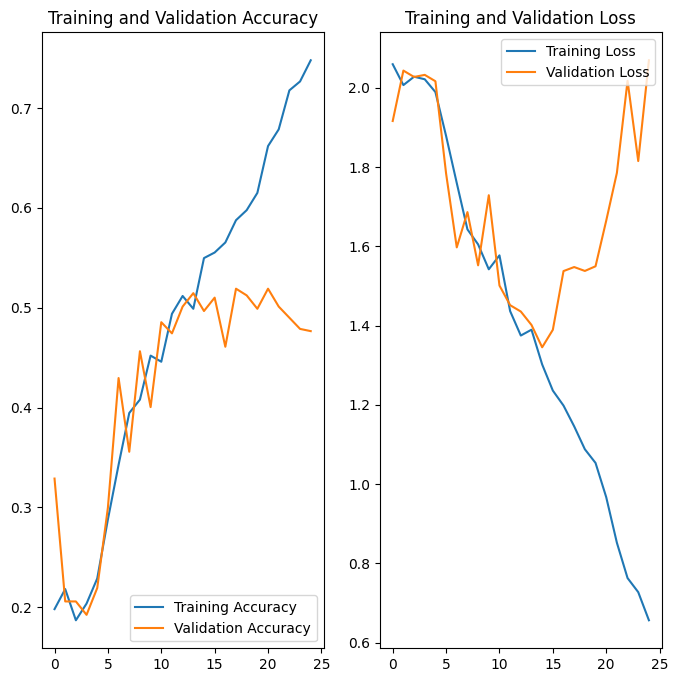

In [28]:
acc = history.history['accuracy']
val_acc = history.history['val_accuracy']

loss = history.history['loss']
val_loss = history.history['val_loss']

epochs_range = range(epochs)

plt.figure(figsize=(8, 8))
plt.subplot(1, 2, 1)
plt.plot(epochs_range, acc, label='Training Accuracy')
plt.plot(epochs_range, val_acc, label='Validation Accuracy')
plt.legend(loc='lower right')
plt.title('Training and Validation Accuracy')

plt.subplot(1, 2, 2)
plt.plot(epochs_range, loss, label='Training Loss')
plt.plot(epochs_range, val_loss, label='Validation Loss')
plt.legend(loc='upper right')
plt.title('Training and Validation Loss')
plt.show()

The model is overfitting because we can see the difference in accuracy in training data & accuracy in the validation data that is almost 20%. 
The training accuracy is just around 70-75% with 25 epochos and the model is yet to learn the many features so increase dataset and introduce dropout.
Also check for data imbalance as it result bais to the model.

# Model 2 : Data Augumentation with drop out layer.

In [37]:
data_augmentation = keras.Sequential(
  [
    layers.RandomFlip("horizontal_and_vertical",input_shape=(img_height,img_width,3)),
    layers.RandomRotation(0.2),
    layers.RandomZoom(0.2),
  ]
)


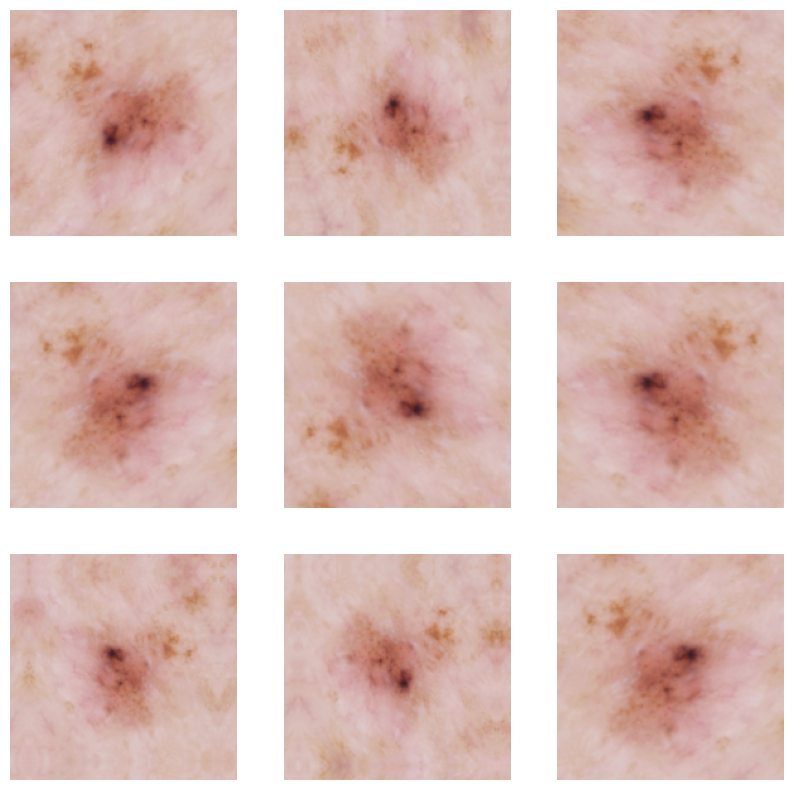

In [38]:
plt.figure(figsize=(10, 10))
for images, _ in train_ds.take(1):
  for i in range(9):
    augmented_images = data_augmentation(images)
    ax = plt.subplot(3, 3, i + 1)
    plt.imshow(augmented_images[0].numpy().astype("uint8"))
    plt.axis("off")


In [43]:
num_classes = 9
model = models.Sequential([
    data_augmentation,  # Add data augmentation as the first layer
    layers.Rescaling(1.0/255, input_shape=(img_height, img_width, 3)),
    
    layers.Conv2D(32, 3, padding="same", activation='relu'),
    layers.MaxPooling2D(),
    
    layers.Conv2D(64, 3, padding="same", activation='relu'),
    layers.MaxPooling2D(),
    
    layers.Conv2D(128, 3, padding="same", activation='relu'),
    layers.MaxPooling2D(),
    layers.Dropout(0.15),
    
    layers.Conv2D(256, 3, padding="same", activation='relu'),
    layers.MaxPooling2D(),
    layers.Dropout(0.20),
    
    layers.Conv2D(512, 3, padding="same", activation='relu'),
    layers.MaxPooling2D(),
    layers.Dropout(0.25),
    
    layers.Flatten(),
    layers.Dense(1024, activation="relu"),
    layers.Dense(num_classes, activation='softmax')
])

In [ ]:
model.summary()

In [45]:
opt = Adam(learning_rate=0.001)
model.compile(optimizer=opt,
              loss= SparseCategoricalCrossentropy(from_logits=True),
              metrics=['accuracy'])

In [46]:
epochs = 25
history = model.fit(
  train_ds,
  validation_data=val_ds,
  epochs=epochs
)

Epoch 1/25


2024-09-09 05:24:44.254563: E tensorflow/core/grappler/optimizers/meta_optimizer.cc:961] layout failed: INVALID_ARGUMENT: Size of values 0 does not match size of permutation 4 @ fanin shape inStatefulPartitionedCall/sequential_7_1/dropout_1/stateless_dropout/SelectV2-2-TransposeNHWCToNCHW-LayoutOptimizer


56/56 ━━━━━━━━━━━━━━━━━━━━ 8s 49ms/step - accuracy: 0.1752 - loss: 2.2705 - val_accuracy: 0.1924 - val_loss: 2.0126
Epoch 2/25
56/56 ━━━━━━━━━━━━━━━━━━━━ 2s 41ms/step - accuracy: 0.2339 - loss: 1.9866 - val_accuracy: 0.2864 - val_loss: 1.9395
Epoch 3/25
56/56 ━━━━━━━━━━━━━━━━━━━━ 2s 41ms/step - accuracy: 0.2926 - loss: 1.8581 - val_accuracy: 0.4228 - val_loss: 1.5839
Epoch 4/25
56/56 ━━━━━━━━━━━━━━━━━━━━ 2s 41ms/step - accuracy: 0.3819 - loss: 1.6469 - val_accuracy: 0.4407 - val_loss: 1.5360
Epoch 5/25
56/56 ━━━━━━━━━━━━━━━━━━━━ 2s 43ms/step - accuracy: 0.4139 - loss: 1.6066 - val_accuracy: 0.4497 - val_loss: 1.5171
Epoch 6/25
56/56 ━━━━━━━━━━━━━━━━━━━━ 2s 41ms/step - accuracy: 0.4771 - loss: 1.4645 - val_accuracy: 0.4765 - val_loss: 1.5364
Epoch 7/25
56/56 ━━━━━━━━━━━━━━━━━━━━ 2s 41ms/step - accuracy: 0.5177 - loss: 1.4137 - val_accuracy: 0.5145 - val_loss: 1.4986
Epoch 8/25
56/56 ━━━━━━━━━━━━━━━━━━━━ 2s 41ms/step - accuracy: 0.4787 - loss: 1.4649 - val_accuracy: 0.4966 - val_loss: 1.

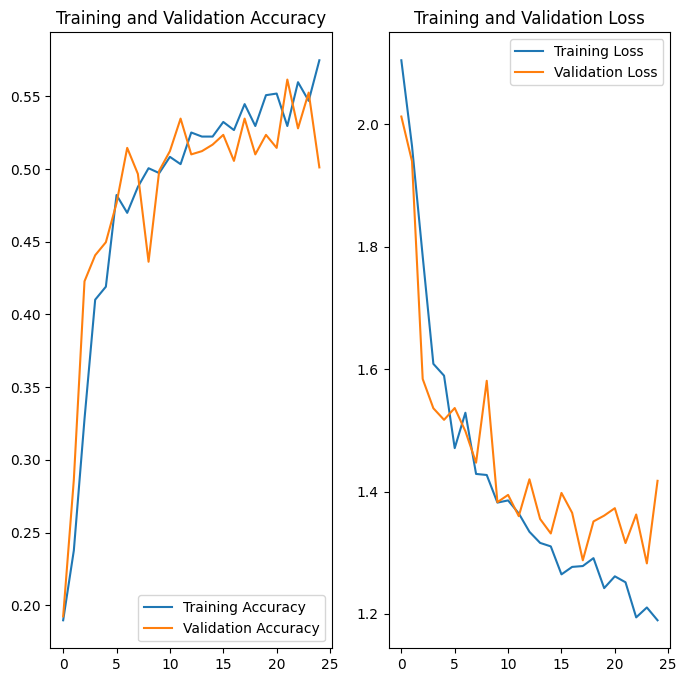

In [47]:
acc = history.history['accuracy']
val_acc = history.history['val_accuracy']

loss = history.history['loss']
val_loss = history.history['val_loss']

epochs_range = range(epochs)

plt.figure(figsize=(8, 8))
plt.subplot(1, 2, 1)
plt.plot(epochs_range, acc, label='Training Accuracy')
plt.plot(epochs_range, val_acc, label='Validation Accuracy')
plt.legend(loc='lower right')
plt.title('Training and Validation Accuracy')

plt.subplot(1, 2, 2)
plt.plot(epochs_range, loss, label='Training Loss')
plt.plot(epochs_range, val_loss, label='Validation Loss')
plt.legend(loc='upper right')
plt.title('Training and Validation Loss')
plt.show()

With data agumenatation and drop layer, the overfitting of the model is adressed to great extend. Earlier the train and validation accuracy difference was nearly 20%, with latest approach it's reduced to 2-3%. 

The accuracy of the model is compromised heavily and decreased by fair bit from previous venilla model. 

Considering above 2 points, there is still a scope of lot of improvement of the model.


# Analysing the class imbalance of the data

total training image count = 2239 

-------------------------------------
Class name =  actinic keratosis
count      =  114
proportion =  0.05091558731576597
-------------------------------------
Class name =  basal cell carcinoma
count      =  376
proportion =  0.16793211255024565
-------------------------------------
Class name =  dermatofibroma
count      =  95
proportion =  0.04242965609647164
-------------------------------------
Class name =  melanoma
count      =  438
proportion =  0.19562304600267977
-------------------------------------
Class name =  nevus
count      =  357
proportion =  0.15944618133095131
-------------------------------------
Class name =  pigmented benign keratosis
count      =  462
proportion =  0.20634211701652524
-------------------------------------
Class name =  seborrheic keratosis
count      =  77
proportion =  0.03439035283608754
-------------------------------------
Class name =  squamous cell carcinoma
count      =  181
proportion =  0.08083966056

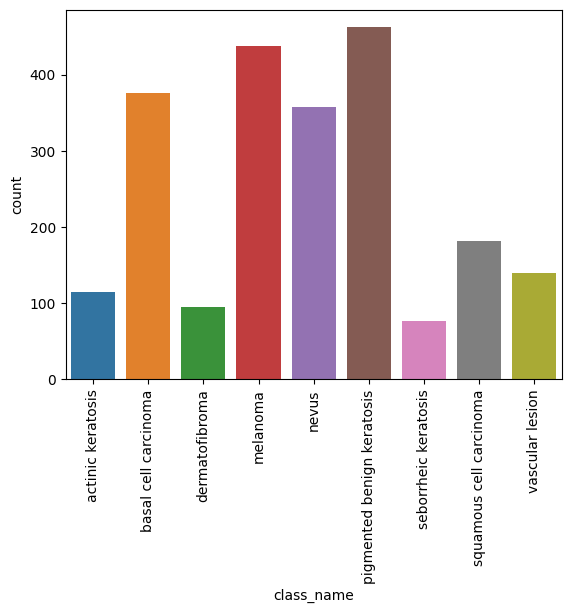

In [48]:
num_classes = len(class_names)
total = 0
all_count = []
class_name = []
for i in range(num_classes):
  count = len(list(data_dir_train.glob(class_names[i]+'/*.jpg')))
  total += count
print("total training image count = {} \n".format(total))
print("-------------------------------------")
for i in range(num_classes):
  count = len(list(data_dir_train.glob(class_names[i]+'/*.jpg')))
  print("Class name = ",class_names[i])
  print("count      = ",count)
  print("proportion = ",count/total)
  print("-------------------------------------")
  all_count.append(count)
  class_name.append(class_names[i])

temp_df = pd.DataFrame(list(zip(all_count, class_name)), columns = ['count', 'class_name'])
sns.barplot(data=temp_df, y="count", x="class_name")
plt.xticks(rotation=90)
plt.show()

Data is hevily imbalance and hence due to that results and predictions will be baised.

# Augmentor : Class balance


In [49]:
!pip install Augmentor

In [50]:
path_to_training_dataset = '../input/skin-cancer9-classesisic/Skin cancer ISIC The International Skin Imaging Collaboration/Train/'
import Augmentor
for i in class_names:
    p = Augmentor.Pipeline(path_to_training_dataset + i, output_directory='/kaggle/working/data/'+i+'/output/')
    p.rotate(probability=0.7, max_left_rotation=10, max_right_rotation=10)
    p.sample(1000) 

Initialised with 114 image(s) found.
Output directory set to /kaggle/working/data/actinic keratosis/output/.

Processing <PIL.Image.Image image mode=RGB size=600x450 at 0x7CA6014EBAC0>: 100%|██████████| 1000/1000 [00:12<00:00, 82.89 Samples/s]                  


Initialised with 376 image(s) found.
Output directory set to /kaggle/working/data/basal cell carcinoma/output/.

Processing <PIL.Image.Image image mode=RGB size=600x450 at 0x7CA602525240>: 100%|██████████| 1000/1000 [00:12<00:00, 81.96 Samples/s]                  


Initialised with 95 image(s) found.
Output directory set to /kaggle/working/data/dermatofibroma/output/.

Processing <PIL.Image.Image image mode=RGB size=600x450 at 0x7CA6014BBE80>: 100%|██████████| 1000/1000 [00:12<00:00, 80.66 Samples/s]                 


Initialised with 438 image(s) found.
Output directory set to /kaggle/working/data/melanoma/output/.

Processing <PIL.Image.Image image mode=RGB size=3072x2304 at 0x7CA60149D120>: 100%|██████████| 1000/1000 [01:06<00:00, 15.08 Samples/s]                 


Initialised with 357 image(s) found.
Output directory set to /kaggle/working/data/nevus/output/.

Processing <PIL.Image.Image image mode=RGB size=2583x2096 at 0x7CA60268B670>: 100%|██████████| 1000/1000 [01:02<00:00, 15.91 Samples/s]                 


Initialised with 462 image(s) found.
Output directory set to /kaggle/working/data/pigmented benign keratosis/output/.

Processing <PIL.Image.Image image mode=RGB size=600x450 at 0x7CA602650AC0>: 100%|██████████| 1000/1000 [00:11<00:00, 85.28 Samples/s]                  


Initialised with 77 image(s) found.
Output directory set to /kaggle/working/data/seborrheic keratosis/output/.

Processing <PIL.Image.Image image mode=RGB size=1024x768 at 0x7CA62011F3A0>: 100%|██████████| 1000/1000 [00:29<00:00, 33.83 Samples/s]                 


Initialised with 181 image(s) found.
Output directory set to /kaggle/working/data/squamous cell carcinoma/output/.

Processing <PIL.JpegImagePlugin.JpegImageFile image mode=RGB size=600x450 at 0x7CA6014BB190>: 100%|██████████| 1000/1000 [00:12<00:00, 80.48 Samples/s]


Initialised with 139 image(s) found.
Output directory set to /kaggle/working/data/vascular lesion/output/.

Processing <PIL.JpegImagePlugin.JpegImageFile image mode=RGB size=600x450 at 0x7CA601468EB0>: 100%|██████████| 1000/1000 [00:12<00:00, 81.24 Samples/s]


In [51]:
output_dir = pathlib.Path('/kaggle/working/data/')
image_count_train = len(list(output_dir.glob('*/output/*.jpg')))
print(image_count_train)

9000


total training image count = 9000 

-------------------------------------
Class name =  actinic keratosis
count      =  1000
proportion =  0.1111111111111111
-------------------------------------
Class name =  basal cell carcinoma
count      =  1000
proportion =  0.1111111111111111
-------------------------------------
Class name =  dermatofibroma
count      =  1000
proportion =  0.1111111111111111
-------------------------------------
Class name =  melanoma
count      =  1000
proportion =  0.1111111111111111
-------------------------------------
Class name =  nevus
count      =  1000
proportion =  0.1111111111111111
-------------------------------------
Class name =  pigmented benign keratosis
count      =  1000
proportion =  0.1111111111111111
-------------------------------------
Class name =  seborrheic keratosis
count      =  1000
proportion =  0.1111111111111111
-------------------------------------
Class name =  squamous cell carcinoma
count      =  1000
proportion =  0.11111111

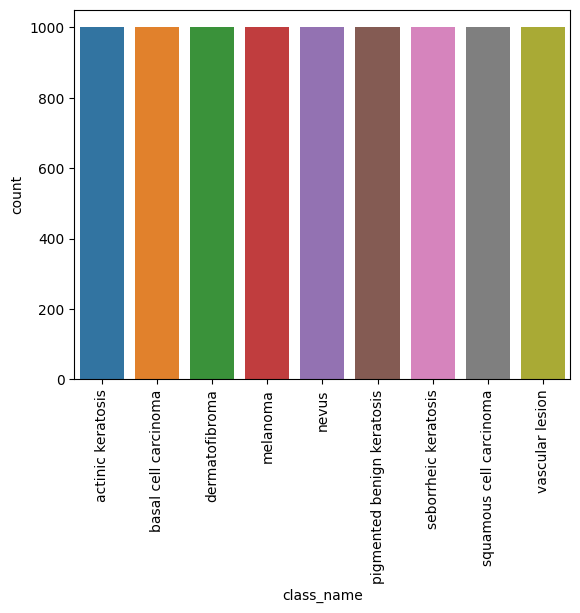

In [52]:
num_classes = len(class_names)
total = 0
all_count = []
class_name = []

for i in range(num_classes):
  count = len(list(output_dir.glob(class_names[i]+'/output/*.jpg')))
  total += count
print("total training image count = {} \n".format(total))
print("-------------------------------------")
for i in range(num_classes):
  count = len(list(output_dir.glob(class_names[i]+'/output/*.jpg')))
  print("Class name = ",class_names[i])
  print("count      = ",count)
  print("proportion = ",count/total)
  print("-------------------------------------")
  all_count.append(count)
  class_name.append(class_names[i])


temp_df = pd.DataFrame(list(zip(all_count, class_name)), columns = ['count', 'class_name'])
sns.barplot(data=temp_df, y="count", x="class_name")
plt.xticks(rotation=90)
plt.show()

# Model with Class balance data.

In [53]:
train_ds = tf.keras.preprocessing.image_dataset_from_directory(
  output_dir,
  seed=123,
  validation_split = 0.2,
  subset = 'training',
  image_size=(img_height, img_width),
  batch_size=batch_size)


Found 9000 files belonging to 9 classes.
Using 7200 files for training.


In [54]:
val_ds = tf.keras.preprocessing.image_dataset_from_directory(
  output_dir,
  seed=123,
  validation_split = 0.2,
  subset = 'validation',
  image_size=(img_height, img_width),
  batch_size=batch_size)


Found 9000 files belonging to 9 classes.
Using 1800 files for validation.


In [55]:
print(train_ds.class_names)

['actinic keratosis', 'basal cell carcinoma', 'dermatofibroma', 'melanoma', 'nevus', 'pigmented benign keratosis', 'seborrheic keratosis', 'squamous cell carcinoma', 'vascular lesion']


In [57]:
num_classes = 9
model = Sequential([layers.Rescaling(1.0/255,input_shape=(img_height,img_width,3))])

model.add(Conv2D(32, 3,padding="same",activation='relu'))
model.add(MaxPool2D())

model.add(Conv2D(64, 3,padding="same",activation='relu'))
model.add(MaxPool2D())

model.add(Conv2D(128, 3,padding="same",activation='relu'))
model.add(MaxPool2D())
model.add(Dropout(0.15))

model.add(Conv2D(256, 3,padding="same",activation='relu'))
model.add(MaxPool2D())
model.add(Dropout(0.20))

model.add(Conv2D(512, 3,padding="same",activation='relu'))
model.add(MaxPool2D())
model.add(Dropout(0.25))

model.add(Flatten())
model.add(Dense(1024,activation="relu"))
model.add(Dense(units=num_classes, activation= 'softmax'))


In [59]:
opt = Adam(learning_rate=0.001)
model.compile(optimizer= opt,
              loss = SparseCategoricalCrossentropy(from_logits=True),
              metrics=['accuracy'])


In [60]:
epochs = 25
history = model.fit(
  train_ds,
  validation_data=val_ds,
  epochs=epochs
)

Epoch 1/25
  6/225 ━━━━━━━━━━━━━━━━━━━━ 5s 26ms/step - accuracy: 0.1076 - loss: 3.0763

I0000 00:00:1725860011.931364     113 asm_compiler.cc:369] ptxas warning : Registers are spilled to local memory in function 'loop_add_subtract_fusion_2', 4 bytes spill stores, 12 bytes spill loads



225/225 ━━━━━━━━━━━━━━━━━━━━ 18s 48ms/step - accuracy: 0.1056 - loss: 2.2801 - val_accuracy: 0.1039 - val_loss: 2.1975
Epoch 2/25
225/225 ━━━━━━━━━━━━━━━━━━━━ 9s 42ms/step - accuracy: 0.1136 - loss: 2.1975 - val_accuracy: 0.1039 - val_loss: 2.1977
Epoch 3/25
225/225 ━━━━━━━━━━━━━━━━━━━━ 9s 41ms/step - accuracy: 0.1104 - loss: 2.1976 - val_accuracy: 0.1056 - val_loss: 2.1978
Epoch 4/25
225/225 ━━━━━━━━━━━━━━━━━━━━ 10s 44ms/step - accuracy: 0.1025 - loss: 2.1973 - val_accuracy: 0.1122 - val_loss: 2.1978
Epoch 5/25
225/225 ━━━━━━━━━━━━━━━━━━━━ 9s 42ms/step - accuracy: 0.1157 - loss: 2.1842 - val_accuracy: 0.1106 - val_loss: 2.1748
Epoch 6/25
225/225 ━━━━━━━━━━━━━━━━━━━━ 9s 41ms/step - accuracy: 0.1819 - loss: 2.0762 - val_accuracy: 0.3472 - val_loss: 1.5724
Epoch 7/25
225/225 ━━━━━━━━━━━━━━━━━━━━ 9s 42ms/step - accuracy: 0.3652 - loss: 1.5704 - val_accuracy: 0.3911 - val_loss: 1.4578
Epoch 8/25
225/225 ━━━━━━━━━━━━━━━━━━━━ 10s 44ms/step - accuracy: 0.4392 - loss: 1.4209 - val_accuracy: 0.

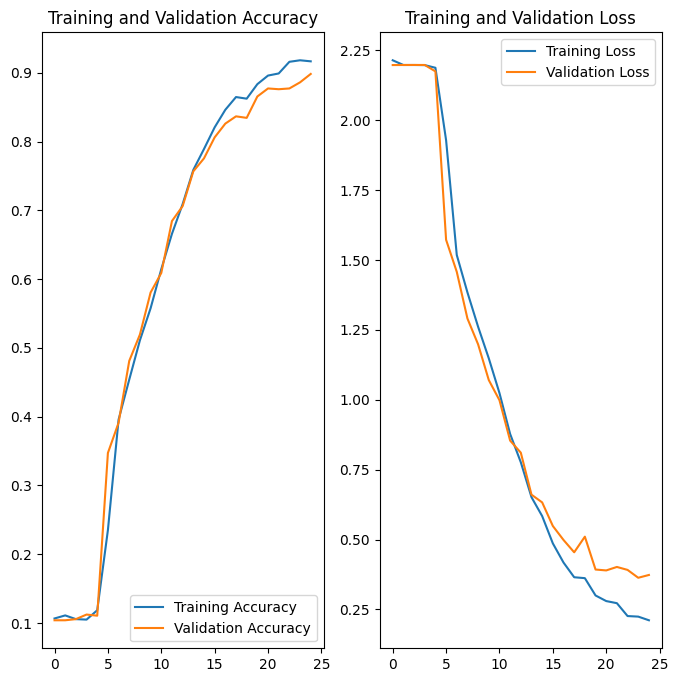

In [61]:
acc = history.history['accuracy']
val_acc = history.history['val_accuracy']

loss = history.history['loss']
val_loss = history.history['val_loss']

epochs_range = range(epochs)

plt.figure(figsize=(8, 8))
plt.subplot(1, 2, 1)
plt.plot(epochs_range, acc, label='Training Accuracy')
plt.plot(epochs_range, val_acc, label='Validation Accuracy')
plt.legend(loc='lower right')
plt.title('Training and Validation Accuracy')

plt.subplot(1, 2, 2)
plt.plot(epochs_range, loss, label='Training Loss')
plt.plot(epochs_range, val_loss, label='Validation Loss')
plt.legend(loc='upper right')
plt.title('Training and Validation Loss')
plt.show()

After rebalance/resampling of the data (that gave equal proportion of data )and raised the accuray of the mdoel to 90%. This addressed the low accurty problem.

overfitting probelm is adressed and now difference between train and val set is nearly 4-5% diff. 

with these results it's conclusive that current module with rebalanced data is the best module.


# Evaluation.

In [63]:
#Create a file to save models
model_save_path = '/kaggle/working/cnn_fc_model.h5'
model.save(model_save_path)


In [66]:
from tensorflow.keras.models import load_model

# Load the entire model
model = load_model('/kaggle/working/cnn_fc_model.h5')

In [69]:
from tensorflow.keras.preprocessing import image

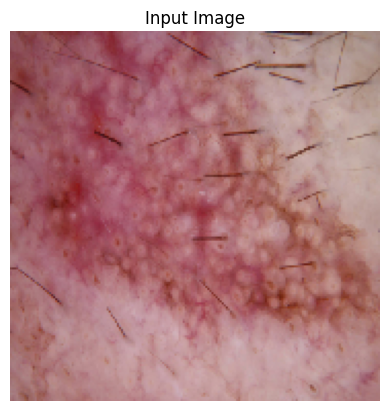

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 17ms/step
Predicted Disease: actinic keratosis


In [71]:
# Load and preprocess the image
img_path = '/kaggle/input/skin-cancer9-classesisic/Skin cancer ISIC The International Skin Imaging Collaboration/Train/actinic keratosis/ISIC_0025780.jpg'
img = image.load_img(img_path, target_size=(img_height, img_width))
img_array = image.img_to_array(img)
img_array = np.expand_dims(img_array, axis=0)  # Add batch dimension

# Visualize the image
plt.imshow(img)
plt.title("Input Image")
plt.axis("off")
plt.show()

# Make a prediction
predictions = model.predict(img_array)
predicted_class = np.argmax(predictions, axis=1)

# Map predicted class to disease label
predicted_label = class_names[predicted_class[0]]
print(f"Predicted Disease: {predicted_label}")